# 🔬 Fluor-RLAT Model Training

Train property prediction models for fluorescent molecules on Google Colab with GPU acceleration.

**Quick Start:**
1. Go to Runtime → Change runtime type → Select **T4 GPU**
2. Run all cells (Runtime → Run all)
3. The notebook will automatically clone the repository and download training data

**Models:**
- `abs` - Absorption wavelength (nm)
- `em` - Emission wavelength (nm)
- `plqy` - Photoluminescence quantum yield (0-1)
- `k` - Log molar absorptivity

**Architecture:** AttentiveFP GNN + Fingerprint CNN fusion (~2.3M parameters per model)

**Expected training time:** ~1-2 hours total on T4 GPU

---

## 1. Install Dependencies

In [1]:
# ============================================================================
# CRITICAL: Disable torch dynamo BEFORE importing torch
# This prevents version conflicts between Colab's PyTorch and DGL
# ============================================================================
import os
os.environ['TORCHDYNAMO_DISABLE'] = '1'

import torch

# Also disable dynamo via config (belt and suspenders)
torch._dynamo.config.suppress_errors = True
torch._dynamo.config.disable = True

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"✅ Torch dynamo disabled")

PyTorch version: 2.4.0+cu121
CUDA available: True
CUDA version: 12.1
GPU: Tesla T4
✅ Torch dynamo disabled


In [2]:
# Install DGL, dgllife, and RDKit (Colab has PyTorch pre-installed)
# DGL wheel selection based on CUDA version

cuda_version = torch.version.cuda
print(f"Detected CUDA version: {cuda_version}")

# Install RDKit first (required by dgllife)
print("Installing RDKit...")
!pip install rdkit -q

# Install DGL for the appropriate CUDA version
if cuda_version and cuda_version.startswith('12'):
    print("Installing DGL for CUDA 12.x...")
    !pip install dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html -q
elif cuda_version and cuda_version.startswith('11'):
    print("Installing DGL for CUDA 11.x...")
    !pip install dgl -f https://data.dgl.ai/wheels/torch-2.1/cu118/repo.html -q
else:
    # Fallback - try latest
    print("Installing DGL (default)...")
    !pip install dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html -q

# Install dgllife for molecular graph utilities
print("Installing dgllife...")
!pip install dgllife -q

# Install tqdm for progress bars (usually present but ensure it's available)
!pip install tqdm -q

print("\n✅ Dependencies installed!")

Detected CUDA version: 12.1
Installing RDKit...
Installing DGL for CUDA 12.x...
Installing dgllife...

✅ Dependencies installed!


In [3]:
# Verify DGL installation
import dgl
print(f"DGL version: {dgl.__version__}")

# Test CUDA with DGL
if torch.cuda.is_available():
    g = dgl.graph(([0, 1], [1, 2]))
    g = g.to('cuda')
    print(f"DGL graph on CUDA: {g.device}")
    print("✅ DGL CUDA support working!")

DGL version: 2.4.0+cu124
DGL graph on CUDA: cuda:0
✅ DGL CUDA support working!


## 2. Mount Google Drive and Setup Directories

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create project directories
import os
os.makedirs('./data', exist_ok=True)
os.makedirs('./models', exist_ok=True)
os.makedirs('./checkpoints', exist_ok=True)

print("✅ Directories created")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Directories created


## 3. Clone Repository and Setup Data

Clone the fluor_tools repository directly from GitHub to access training data.

In [5]:
# Clone the repository
import os

REPO_URL = "https://github.com/markste-in/fluor_tools.git"
REPO_DIR = "fluor_tools"

if not os.path.exists(REPO_DIR):
    print(f"📥 Cloning repository from {REPO_URL}...")
    !git clone {REPO_URL}
    print("✅ Repository cloned!")
else:
    print(f"✅ Repository already exists at {REPO_DIR}")
    # Optionally pull latest changes
    !cd {REPO_DIR} && git pull

# Set data path to the cloned repo
DATA_DIR = f'./{REPO_DIR}/Fluor-RLAT/data'
print(f"📁 Data directory: {DATA_DIR}")

✅ Repository already exists at fluor_tools
Already up to date.
📁 Data directory: ./fluor_tools/Fluor-RLAT/data


## 4. Verify GPU Availability

In [6]:
# Check GPU details
!nvidia-smi

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n🖥️ Using device: {device}")

if device == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    props = torch.cuda.get_device_properties(0)
    print(f"   Memory: {props.total_memory / 1e9:.1f} GB")
    print(f"   Compute capability: {props.major}.{props.minor}")
else:
    print("⚠️ No GPU detected! Training will be slow.")
    print("   Go to Runtime → Change runtime type → GPU")

Sun Feb 15 15:22:15 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             31W /   70W |     107MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 5. Configure Environment Variables

In [7]:
# Configure CUDA memory management to prevent OOM errors
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Set random seeds for reproducibility
import random
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    # Enable TF32 for faster training on Ampere GPUs (A100)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

print("✅ Environment configured")

✅ Environment configured


## 6. Load and Verify Training Data

In [8]:
# Verify data files are present
DATA_DIR = './fluor_tools/Fluor-RLAT/data'

required_base = ['train', 'valid']
targets = ['abs', 'em', 'plqy', 'k']
file_types = ['', '_smiles', '_sol']

print(f"Checking data files in: {DATA_DIR}")
missing = []
found = []

for base in required_base:
    for target in targets:
        for ftype in file_types:
            filename = f'{base}{ftype}_{target}.csv'
            path = os.path.join(DATA_DIR, filename)
            if os.path.exists(path):
                size = os.path.getsize(path) / 1024 / 1024
                found.append((filename, size))
            else:
                missing.append(filename)

print(f"\n✅ Found {len(found)} files:")
for fname, size in found[:6]:
    print(f"   {fname} ({size:.1f} MB)")
if len(found) > 6:
    print(f"   ... and {len(found) - 6} more")

if missing:
    print(f"\n❌ Missing {len(missing)} files:")
    for fname in missing[:5]:
        print(f"   {fname}")
    print("\n⚠️ Please upload data before training!")
else:
    print("\n✅ All required files present!")

Checking data files in: ./fluor_tools/Fluor-RLAT/data

✅ Found 24 files:
   train_abs.csv (9.3 MB)
   train_smiles_abs.csv (42.9 MB)
   train_sol_abs.csv (42.9 MB)
   train_em.csv (7.2 MB)
   train_smiles_em.csv (32.9 MB)
   train_sol_em.csv (32.9 MB)
   ... and 18 more

✅ All required files present!


In [9]:
# Load sample counts
import pandas as pd

print("Dataset sizes:")
for target in ['abs', 'em', 'plqy', 'k']:
    train_path = os.path.join(DATA_DIR, f'train_{target}.csv')
    valid_path = os.path.join(DATA_DIR, f'valid_{target}.csv')
    
    if os.path.exists(train_path) and os.path.exists(valid_path):
        train_df = pd.read_csv(train_path)
        valid_df = pd.read_csv(valid_path)
        print(f"  {target.upper()}: {len(train_df):,} train / {len(valid_df):,} valid")

Dataset sizes:
  ABS: 21,948 train / 3,132 valid
  EM: 16,833 train / 2,370 valid
  PLQY: 12,998 train / 1,855 valid
  K: 6,976 train / 952 valid


## 7. Initialize Model Architecture

Define the complete model architecture including:
- AttentiveFP Graph Neural Network
- Fingerprint CNN with attention (for abs/em)
- Simple FC network (for plqy/k)

In [10]:
# Import all required libraries
import copy
import time
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm.notebook import tqdm

import dgl
from dgllife.model.gnn import AttentiveFPGNN
from dgllife.model.readout import AttentiveFPReadout
from dgllife.utils import (
    smiles_to_bigraph,
    AttentiveFPAtomFeaturizer,
    AttentiveFPBondFeaturizer,
)

print("✅ All imports successful")

✅ All imports successful


In [11]:
# ============================================================================
# Configuration
# ============================================================================

BATCH_SIZE = 32
LEARNING_RATE = 1e-3
GRAPH_FEAT_SIZE = 256

# Model configurations per target (from pretrained model analysis)
MODEL_CONFIGS = {
    'abs': {
        'num_layers': 2,
        'num_timesteps': 2,
        'dropout': 0.3,
        'alpha': 0.1,  # LDS alpha
        'model_type': 'attention_cnn',
    },
    'em': {
        'num_layers': 2,
        'num_timesteps': 1,
        'dropout': 0.3,
        'alpha': 0.0,
        'model_type': 'attention_cnn',
    },
    'plqy': {
        'num_layers': 2,
        'num_timesteps': 3,
        'dropout': 0.4,
        'alpha': 0.2,
        'model_type': 'simple_fc',
    },
    'k': {
        'num_layers': 3,
        'num_timesteps': 1,
        'dropout': 0.3,
        'alpha': 0.6,
        'model_type': 'simple_fc',
    },
}

# Featurizers for molecular graphs
ATOM_FEATURIZER = AttentiveFPAtomFeaturizer(atom_data_field='hv')
BOND_FEATURIZER = AttentiveFPBondFeaturizer(bond_data_field='he')

print("✅ Configuration loaded")

✅ Configuration loaded


In [12]:
# ============================================================================
# Model Architecture Classes
# ============================================================================

class FingerprintAttentionCNN(nn.Module):
    """CNN with attention for fingerprint processing (used by abs/em models)."""
    
    def __init__(self, input_dim, hidden_dim=256, output_dim=512, dropout=0.3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.fc_in = nn.Linear(input_dim, hidden_dim)
        self.conv1 = nn.Conv1d(1, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv_attn = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc_in(x)
        x = self.relu(x)
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.relu(x)
        attn_map = self.conv_attn(x)
        attn_weights = torch.softmax(attn_map, dim=-1)
        x = x * attn_weights
        x = x.mean(dim=-1)
        x = self.fc_out(x)
        x = self.dropout(x)
        return x


class GraphFingerprintsModelAttentionCNN(nn.Module):
    """Model for abs/em: AttentiveFP GNN + Attention CNN for fingerprints."""
    
    def __init__(self, node_feat_size, edge_feat_size, solvent_dim, smiles_extra_dim,
                 graph_feat_size=256, num_layers=2, num_timesteps=2, n_tasks=1, dropout=0.3):
        super().__init__()
        
        # Store solvent_dim for use in forward pass
        self.solvent_dim = solvent_dim
        
        self.gnn = AttentiveFPGNN(
            node_feat_size=node_feat_size,
            edge_feat_size=edge_feat_size,
            num_layers=num_layers,
            graph_feat_size=graph_feat_size,
            dropout=dropout
        )
        
        self.readout = AttentiveFPReadout(
            feat_size=graph_feat_size,
            num_timesteps=num_timesteps,
            dropout=dropout
        )
        
        self.solvent_extractor = nn.Sequential(
            nn.Linear(solvent_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.fp_extractor = FingerprintAttentionCNN(
            input_dim=smiles_extra_dim,
            hidden_dim=256,
            output_dim=512,
            dropout=dropout
        )
        
        self.predict = nn.Sequential(
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, n_tasks)
        )
        
    def forward(self, graph, node_feats, edge_feats, fingerprints):
        # Use stored solvent_dim instead of hardcoded value
        solvent_feat = fingerprints[:, :self.solvent_dim]
        smiles_extra_feat = fingerprints[:, self.solvent_dim:]
        
        node_out = self.gnn(graph, node_feats, edge_feats)
        graph_out = self.readout(graph, node_out, False)
        solvent_out = self.solvent_extractor(solvent_feat)
        smiles_extra_out = self.fp_extractor(smiles_extra_feat)
        
        combined = torch.cat([graph_out, solvent_out, smiles_extra_out], dim=1)
        return self.predict(combined)


class GraphFingerprintsModelSimpleFC(nn.Module):
    """Model for plqy/k: AttentiveFP GNN + Simple FC for fingerprints."""
    
    def __init__(self, node_feat_size, edge_feat_size, fp_size,
                 graph_feat_size=256, num_layers=2, num_timesteps=2, n_tasks=1, dropout=0.3):
        super().__init__()
        
        self.gnn = AttentiveFPGNN(
            node_feat_size=node_feat_size,
            edge_feat_size=edge_feat_size,
            num_layers=num_layers,
            graph_feat_size=graph_feat_size,
            dropout=dropout
        )
        
        self.readout = AttentiveFPReadout(
            feat_size=graph_feat_size,
            num_timesteps=num_timesteps,
            dropout=dropout
        )
        
        self.fp_fc = nn.Sequential(
            nn.Linear(fp_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.predict = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, n_tasks)
        )
        
    def forward(self, graph, node_feats, edge_feats, fingerprints):
        node_out = self.gnn(graph, node_feats, edge_feats)
        graph_out = self.readout(graph, node_out, False)
        fp_out = self.fp_fc(fingerprints)
        combined = torch.cat([graph_out, fp_out], dim=1)
        return self.predict(combined)


print("✅ Model classes defined")

✅ Model classes defined


In [13]:
# ============================================================================
# Dataset and Data Loading
# ============================================================================

class MolecularDataset(Dataset):
    """Dataset for molecular property prediction."""
    
    def __init__(self, graphs, fingerprints, labels, masks=None, weights=None):
        self.graphs = graphs
        self.fingerprints = fingerprints
        self.labels = labels
        self.masks = masks
        self.weights = weights
        
    def __len__(self):
        return len(self.graphs)
    
    def __getitem__(self, idx):
        return (
            self.graphs[idx],
            self.fingerprints[idx],
            self.labels[idx],
            self.masks[idx] if self.masks is not None else 1.0,
            self.weights[idx] if self.weights is not None else 1.0
        )


def collate_fn(batch):
    """Custom collate function for batching molecular graphs."""
    graphs, fps, labels, masks, weights = zip(*batch)
    batched_graph = dgl.batch(graphs)
    fps = torch.stack(fps)
    labels = torch.stack(labels)
    masks = torch.tensor(masks, dtype=torch.float32) if masks[0] is not None else None
    weights = torch.tensor(weights, dtype=torch.float32) if weights[0] is not None else None
    return batched_graph, fps, labels, masks, weights


def compute_lds_weights(labels, alpha=0.5, kernel_size=5):
    """Compute Label Distribution Smoothing weights."""
    if alpha == 0:
        return np.ones(len(labels))
    
    n_bins = 100
    label_min, label_max = labels.min(), labels.max()
    bins = np.linspace(label_min, label_max, n_bins + 1)
    bin_indices = np.digitize(labels, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    bin_counts = np.bincount(bin_indices, minlength=n_bins).astype(float)
    kernel = np.ones(kernel_size) / kernel_size
    smoothed_counts = np.convolve(bin_counts, kernel, mode='same')
    smoothed_counts = np.maximum(smoothed_counts, 1)
    
    effective_counts = bin_counts ** alpha * smoothed_counts ** (1 - alpha)
    effective_counts = np.maximum(effective_counts, 1)
    
    weights = 1.0 / effective_counts[bin_indices]
    weights = weights / weights.mean()
    
    return weights.astype(np.float32)


def smiles_to_graph(smiles):
    """Convert SMILES to DGL graph with AttentiveFP featurization."""
    try:
        graph = smiles_to_bigraph(
            smiles,
            node_featurizer=ATOM_FEATURIZER,
            edge_featurizer=BOND_FEATURIZER,
            add_self_loop=False
        )
        return graph
    except Exception as e:
        return None


print("✅ Dataset classes defined")

✅ Dataset classes defined


In [14]:
# ============================================================================
# Data Loading Functions
# ============================================================================

def load_and_process_data(target, data_dir, config):
    """Load and process training/validation data for a target property."""
    
    data_dir = Path(data_dir)
    
    # Load main data files
    train_df = pd.read_csv(data_dir / f'train_{target}.csv')
    valid_df = pd.read_csv(data_dir / f'valid_{target}.csv')
    
    # Load fingerprint files
    train_smiles_fp = pd.read_csv(data_dir / f'train_smiles_{target}.csv')
    train_sol_fp = pd.read_csv(data_dir / f'train_sol_{target}.csv')
    valid_smiles_fp = pd.read_csv(data_dir / f'valid_smiles_{target}.csv')
    valid_sol_fp = pd.read_csv(data_dir / f'valid_sol_{target}.csv')
    
    print(f"   Train samples: {len(train_df)}")
    print(f"   Valid samples: {len(valid_df)}")
    
    # Extract labels
    train_labels = train_df[target].values.reshape(-1, 1).astype(np.float32)
    valid_labels = valid_df[target].values.reshape(-1, 1).astype(np.float32)
    
    # Normalize labels
    scaler = StandardScaler()
    train_labels_scaled = scaler.fit_transform(train_labels)
    valid_labels_scaled = scaler.transform(valid_labels)
    
    # Extract and normalize numeric features
    numeric_cols = train_df.columns[8:16].tolist() if len(train_df.columns) > 16 else []
    
    scaler_num = MinMaxScaler()
    if numeric_cols:
        train_numeric = scaler_num.fit_transform(train_df[numeric_cols].values)
        valid_numeric = scaler_num.transform(valid_df[numeric_cols].values)
    else:
        train_numeric = np.zeros((len(train_df), 0))
        valid_numeric = np.zeros((len(valid_df), 0))
    
    # Combine fingerprints
    train_sol = train_sol_fp.values.astype(np.float32)
    train_smiles = train_smiles_fp.values.astype(np.float32)
    valid_sol = valid_sol_fp.values.astype(np.float32)
    valid_smiles = valid_smiles_fp.values.astype(np.float32)
    
    # Get scaffold flags if present
    scaffold_cols = [c for c in train_df.columns if c.startswith('fragment_')]
    if scaffold_cols:
        train_scaffold = train_df[scaffold_cols].values.astype(np.float32)
        valid_scaffold = valid_df[scaffold_cols].values.astype(np.float32)
    else:
        train_scaffold = np.zeros((len(train_df), 0), dtype=np.float32)
        valid_scaffold = np.zeros((len(valid_df), 0), dtype=np.float32)
    
    # Combine all features
    train_fp = np.hstack([train_sol, train_smiles, train_numeric, train_scaffold])
    valid_fp = np.hstack([valid_sol, valid_smiles, valid_numeric, valid_scaffold])
    
    solvent_dim = train_sol.shape[1]
    smiles_extra_dim = train_fp.shape[1] - solvent_dim
    fp_size = train_fp.shape[1]
    
    print(f"   Total fingerprint dimensions: {fp_size}")
    
    # Compute LDS weights
    alpha = config['alpha']
    train_weights = compute_lds_weights(train_labels.flatten(), alpha=alpha)
    print(f"   LDS alpha: {alpha}, weight range: [{train_weights.min():.2f}, {train_weights.max():.2f}]")
    
    # Convert SMILES to graphs
    print("   Converting SMILES to graphs...")
    
    train_smiles_list = train_df['smiles'].tolist()
    valid_smiles_list = valid_df['smiles'].tolist()
    
    train_graphs = []
    for smi in tqdm(train_smiles_list, desc="   Train graphs", leave=False):
        g = smiles_to_graph(smi)
        if g is None:
            g = dgl.graph(([0], [0]))
            g.ndata['hv'] = torch.zeros(1, 39)
            g.edata['he'] = torch.zeros(1, 10)
        train_graphs.append(g)
    
    valid_graphs = []
    for smi in tqdm(valid_smiles_list, desc="   Valid graphs", leave=False):
        g = smiles_to_graph(smi)
        if g is None:
            g = dgl.graph(([0], [0]))
            g.ndata['hv'] = torch.zeros(1, 39)
            g.edata['he'] = torch.zeros(1, 10)
        valid_graphs.append(g)
    
    print(f"   ✅ Converted {len(train_graphs)} train + {len(valid_graphs)} valid graphs")
    
    # Create datasets
    train_data = MolecularDataset(
        graphs=train_graphs,
        fingerprints=torch.tensor(train_fp, dtype=torch.float32),
        labels=torch.tensor(train_labels_scaled, dtype=torch.float32),
        masks=None,
        weights=train_weights
    )
    
    valid_data = MolecularDataset(
        graphs=valid_graphs,
        fingerprints=torch.tensor(valid_fp, dtype=torch.float32),
        labels=torch.tensor(valid_labels_scaled, dtype=torch.float32),
        masks=None,
        weights=None
    )
    
    return {
        'train_data': train_data,
        'valid_data': valid_data,
        'scaler': scaler,
        'scaler_num': scaler_num,
        'config': config,
        'solvent_dim': solvent_dim,
        'smiles_extra_dim': smiles_extra_dim,
        'fp_size': fp_size,
    }


print("✅ Data loading functions defined")

✅ Data loading functions defined


In [15]:
# ============================================================================
# Training Functions
# ============================================================================

def train_epoch(model, dataloader, optimizer, criterion, device, use_lds=True):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    num_batches = 0
    
    for batch in dataloader:
        graphs, fps, labels, masks, weights = batch
        
        graphs = graphs.to(device)
        fps = fps.to(device)
        labels = labels.to(device)
        
        node_feats = graphs.ndata['hv']
        edge_feats = graphs.edata.get('he', None)
        
        optimizer.zero_grad()
        predictions = model(graphs, node_feats, edge_feats, fps)
        
        if use_lds and weights is not None:
            weights = weights.to(device)
            loss = (criterion(predictions, labels) * weights.unsqueeze(1)).mean()
        else:
            loss = criterion(predictions, labels).mean()
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches


def validate(model, dataloader, criterion, device):
    """Validate model on validation set."""
    model.eval()
    total_loss = 0
    num_batches = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            graphs, fps, labels, masks, _ = batch
            
            graphs = graphs.to(device)
            fps = fps.to(device)
            labels = labels.to(device)
            
            node_feats = graphs.ndata['hv']
            edge_feats = graphs.edata.get('he', None)
            
            predictions = model(graphs, node_feats, edge_feats, fps)
            loss = criterion(predictions, labels).mean()
            
            total_loss += loss.item()
            num_batches += 1
            
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    return total_loss / num_batches, all_preds, all_labels


print("✅ Training functions defined")

✅ Training functions defined


## 8. Run Training Loop

In [16]:
# ============================================================================
# Main Training Function with Checkpoint Resumption
# ============================================================================

def find_checkpoint(checkpoint_dir, target):
    """Check if a checkpoint exists for the given target."""
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{target}.pth')
    if os.path.exists(checkpoint_path):
        return checkpoint_path
    return None


def load_checkpoint(checkpoint_path, model, optimizer, device):
    """Load checkpoint and return training state."""
    print(f"   📂 Loading checkpoint from: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Move optimizer states to device
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)
    
    return {
        'epoch': checkpoint['epoch'],
        'best_val_loss': checkpoint['best_val_loss'],
        'history': checkpoint.get('history', {'train_loss': [], 'val_loss': []}),
        'epochs_without_improvement': checkpoint.get('epochs_without_improvement', 0),
        'best_model_state': checkpoint['model_state_dict'],
    }


def save_checkpoint(checkpoint_dir, target, epoch, model, optimizer, best_val_loss, 
                    best_model_state, history, epochs_without_improvement, scaler, config):
    """Save comprehensive checkpoint with all training state."""
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{target}.pth')
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': best_model_state,
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_loss': best_val_loss,
        'history': history,
        'epochs_without_improvement': epochs_without_improvement,
        'scaler_mean': scaler.mean_.tolist(),
        'scaler_scale': scaler.scale_.tolist(),
        'config': config,
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
    }, checkpoint_path)
    
    return checkpoint_path


def train_model(target, data_dir='./data', output_dir='./models', 
                checkpoint_dir='./checkpoints', epochs=200, patience=20, device='cuda',
                resume=True):
    """Train a single property prediction model with checkpoint saving and resumption."""
    
    print(f"\n{'='*60}")
    print(f"🚀 Training model for: {target.upper()}")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    # Get model config
    config = MODEL_CONFIGS[target]
    print(f"   Config: {config}")
    
    # Get feature dimensions
    sample_graph = smiles_to_graph('CCO')
    n_feats = sample_graph.ndata['hv'].shape[1]
    e_feats = sample_graph.edata['he'].shape[1]
    print(f"   Node features: {n_feats}, Edge features: {e_feats}")
    
    # Load data
    print(f"\n📂 Loading data for {target}...")
    data = load_and_process_data(target, data_dir, config)
    
    # Create data loaders with GPU optimization
    train_loader = DataLoader(
        data['train_data'],
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=2,
        pin_memory=True
    )
    
    valid_loader = DataLoader(
        data['valid_data'],
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2,
        pin_memory=True
    )
    
    # Initialize model
    if config['model_type'] == 'attention_cnn':
        model = GraphFingerprintsModelAttentionCNN(
            node_feat_size=n_feats,
            edge_feat_size=e_feats,
            solvent_dim=data['solvent_dim'],
            smiles_extra_dim=data['smiles_extra_dim'],
            graph_feat_size=GRAPH_FEAT_SIZE,
            num_layers=config['num_layers'],
            num_timesteps=config['num_timesteps'],
            n_tasks=1,
            dropout=config['dropout']
        ).to(device)
    else:
        model = GraphFingerprintsModelSimpleFC(
            node_feat_size=n_feats,
            edge_feat_size=e_feats,
            fp_size=data['fp_size'],
            graph_feat_size=GRAPH_FEAT_SIZE,
            num_layers=config['num_layers'],
            num_timesteps=config['num_timesteps'],
            n_tasks=1,
            dropout=config['dropout']
        ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"   Model parameters: {total_params:,}")
    
    # Loss and optimizer
    criterion = nn.MSELoss(reduction='none')
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Check for existing checkpoint and resume if available
    start_epoch = 1
    best_val_loss = float('inf')
    best_model_state = None
    epochs_without_improvement = 0
    history = {'train_loss': [], 'val_loss': []}
    
    checkpoint_path = find_checkpoint(checkpoint_dir, target) if resume else None
    
    if checkpoint_path:
        try:
            ckpt = load_checkpoint(checkpoint_path, model, optimizer, device)
            start_epoch = ckpt['epoch'] + 1
            best_val_loss = ckpt['best_val_loss']
            best_model_state = ckpt['best_model_state']
            history = ckpt['history']
            epochs_without_improvement = ckpt['epochs_without_improvement']
            
            print(f"   ✅ Resuming from epoch {start_epoch}")
            print(f"   Previous best val loss: {best_val_loss:.4f}")
            print(f"   Previous epochs trained: {ckpt['epoch']}")
            print(f"   Epochs without improvement: {epochs_without_improvement}")
            
            # Check if already completed
            if epochs_without_improvement >= patience:
                print(f"   ⏹️ Training already completed (early stopped at epoch {ckpt['epoch']})")
                # Load best model and return results
                model.load_state_dict(best_model_state)
                _, val_preds, val_labels = validate(model, valid_loader, criterion, device)
                val_preds_orig = data['scaler'].inverse_transform(val_preds)
                val_labels_orig = data['scaler'].inverse_transform(val_labels)
                
                return {
                    'target': target,
                    'best_val_loss': best_val_loss,
                    'mae': mean_absolute_error(val_labels_orig, val_preds_orig),
                    'rmse': np.sqrt(mean_squared_error(val_labels_orig, val_preds_orig)),
                    'r2': r2_score(val_labels_orig, val_preds_orig),
                    'epochs_trained': ckpt['epoch'],
                    'training_time': 0,
                    'history': history,
                    'resumed': True,
                    'already_complete': True,
                }
            
            if start_epoch > epochs:
                print(f"   ⏹️ Already trained for {epochs} epochs")
                model.load_state_dict(best_model_state)
                _, val_preds, val_labels = validate(model, valid_loader, criterion, device)
                val_preds_orig = data['scaler'].inverse_transform(val_preds)
                val_labels_orig = data['scaler'].inverse_transform(val_labels)
                
                return {
                    'target': target,
                    'best_val_loss': best_val_loss,
                    'mae': mean_absolute_error(val_labels_orig, val_preds_orig),
                    'rmse': np.sqrt(mean_squared_error(val_labels_orig, val_preds_orig)),
                    'r2': r2_score(val_labels_orig, val_preds_orig),
                    'epochs_trained': ckpt['epoch'],
                    'training_time': 0,
                    'history': history,
                    'resumed': True,
                    'already_complete': True,
                }
                
        except Exception as e:
            print(f"   ⚠️ Failed to load checkpoint: {e}")
            print(f"   Starting fresh training...")
            start_epoch = 1
            best_val_loss = float('inf')
            best_model_state = None
            epochs_without_improvement = 0
            history = {'train_loss': [], 'val_loss': []}
    else:
        print(f"   📝 No checkpoint found, starting fresh training")
    
    use_lds = config['alpha'] > 0
    
    remaining_epochs = epochs - start_epoch + 1
    print(f"\n📈 Training epochs {start_epoch} to {epochs} ({remaining_epochs} remaining)")
    print(f"   Patience: {patience}, Using LDS: {use_lds}")
    
    # Monitor GPU memory
    if device == 'cuda':
        torch.cuda.reset_peak_memory_stats()
    
    pbar = tqdm(range(start_epoch, epochs + 1), desc="Training", unit="epoch")
    final_epoch = start_epoch - 1
    
    for epoch in pbar:
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device, use_lds)
        val_loss, val_preds, val_labels = validate(model, valid_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
            status = "✓ best"
        else:
            epochs_without_improvement += 1
            status = ""
        
        # Save checkpoint (every epoch for robustness against disconnection)
        save_checkpoint(
            checkpoint_dir, target, epoch, model, optimizer,
            best_val_loss, best_model_state, history, 
            epochs_without_improvement, data['scaler'], config
        )
        
        # Update progress bar
        pbar.set_postfix({
            'train': f'{train_loss:.4f}',
            'val': f'{val_loss:.4f}',
            'best': f'{best_val_loss:.4f}',
            'no_improv': epochs_without_improvement,
        })
        
        final_epoch = epoch
        
        # Early stopping
        if epochs_without_improvement >= patience:
            print(f"\n⏹️ Early stopping at epoch {epoch}")
            break
    
    # Load best model and evaluate
    model.load_state_dict(best_model_state)
    
    _, val_preds, val_labels = validate(model, valid_loader, criterion, device)
    
    # Inverse transform predictions
    val_preds_orig = data['scaler'].inverse_transform(val_preds)
    val_labels_orig = data['scaler'].inverse_transform(val_labels)
    
    mae = mean_absolute_error(val_labels_orig, val_preds_orig)
    rmse = np.sqrt(mean_squared_error(val_labels_orig, val_preds_orig))
    r2 = r2_score(val_labels_orig, val_preds_orig)
    
    print(f"\n📊 Final Metrics (original scale):")
    print(f"   MAE:  {mae:.4f}")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   R²:   {r2:.4f}")
    
    # Report GPU memory usage
    if device == 'cuda':
        peak_memory = torch.cuda.max_memory_allocated() / 1e9
        print(f"   Peak GPU memory: {peak_memory:.2f} GB")
    
    # Save final model
    os.makedirs(output_dir, exist_ok=True)
    model_path = os.path.join(output_dir, f'Model_{target}.pth')
    torch.save(best_model_state, model_path)
    print(f"\n💾 Model saved to: {model_path}")
    
    # Calculate training time
    elapsed_time = time.time() - start_time
    hours, remainder = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    time_str = f"{int(hours)}h {int(minutes)}m {int(seconds)}s"
    print(f"⏱️ Training time: {time_str}")
    
    return {
        'target': target,
        'best_val_loss': best_val_loss,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'epochs_trained': final_epoch,
        'training_time': elapsed_time,
        'history': history,
        'resumed': checkpoint_path is not None,
    }


print("✅ Main training function defined (with checkpoint resumption)")

✅ Main training function defined (with checkpoint resumption)


In [17]:
# ============================================================================
# Training Configuration
# ============================================================================

# Paths - using cloned repository data
DATA_DIR = './fluor_tools/Fluor-RLAT/data'
OUTPUT_DIR = './models'
CHECKPOINT_DIR = '/content/drive/MyDrive/fluor_checkpoints'  # Save checkpoints to Drive

# Training parameters
EPOCHS = 200
PATIENCE = 20

# Resume from checkpoints if they exist
RESUME_FROM_CHECKPOINT = True  # Set to False to start fresh

# Select which models to train
# Options: 'abs', 'em', 'plqy', 'k'
TARGETS = ['abs', 'em', 'plqy', 'k']  # Train all models
# TARGETS = ['abs']  # Train only absorption model

print(f"🎯 Models to train: {TARGETS}")
print(f"📁 Data directory: {DATA_DIR}")
print(f"📁 Output directory: {OUTPUT_DIR}")
print(f"💾 Checkpoints: {CHECKPOINT_DIR}")
print(f"⚙️  Epochs: {EPOCHS}, Patience: {PATIENCE}")
print(f"🔄 Resume from checkpoint: {RESUME_FROM_CHECKPOINT}")

🎯 Models to train: ['abs', 'em', 'plqy', 'k']
📁 Data directory: ./fluor_tools/Fluor-RLAT/data
📁 Output directory: ./models
💾 Checkpoints: /content/drive/MyDrive/fluor_checkpoints
⚙️  Epochs: 200, Patience: 20
🔄 Resume from checkpoint: True


In [18]:
# ============================================================================
# Check Existing Checkpoints
# ============================================================================

print(f"🔍 Checking for existing checkpoints in: {CHECKPOINT_DIR}\n")

if os.path.exists(CHECKPOINT_DIR):
    found_checkpoints = []
    for target in TARGETS:
        ckpt_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_{target}.pth')
        if os.path.exists(ckpt_path):
            try:
                ckpt = torch.load(ckpt_path, map_location='cpu')
                epoch = ckpt.get('epoch', '?')
                val_loss = ckpt.get('best_val_loss', '?')
                timestamp = ckpt.get('timestamp', 'unknown')
                epochs_no_improv = ckpt.get('epochs_without_improvement', 0)
                
                status = "✅ Complete" if epochs_no_improv >= PATIENCE or epoch >= EPOCHS else "🔄 In progress"
                
                found_checkpoints.append({
                    'target': target,
                    'epoch': epoch,
                    'val_loss': val_loss,
                    'timestamp': timestamp,
                    'status': status,
                    'epochs_no_improv': epochs_no_improv,
                })
                print(f"  📦 {target.upper()}: Epoch {epoch}, Val Loss: {val_loss:.4f}, {status}")
                print(f"      Last saved: {timestamp}, No improvement: {epochs_no_improv}/{PATIENCE}")
            except Exception as e:
                print(f"  ⚠️  {target.upper()}: Checkpoint exists but failed to read: {e}")
        else:
            print(f"  ⬜ {target.upper()}: No checkpoint found")
    
    if found_checkpoints and RESUME_FROM_CHECKPOINT:
        print(f"\n✅ Will resume training from existing checkpoints")
    elif found_checkpoints and not RESUME_FROM_CHECKPOINT:
        print(f"\n⚠️  Checkpoints exist but RESUME_FROM_CHECKPOINT=False")
        print(f"   Training will start fresh (existing checkpoints ignored)")
else:
    print(f"  📁 Checkpoint directory does not exist yet")
    print(f"  📝 Will start fresh training for all models")

🔍 Checking for existing checkpoints in: /content/drive/MyDrive/fluor_checkpoints

  📁 Checkpoint directory does not exist yet
  📝 Will start fresh training for all models


In [19]:
# ============================================================================
# 🚀 START TRAINING
# ============================================================================

total_start = time.time()
results = []

for target in TARGETS:
    result = train_model(
        target=target,
        data_dir=DATA_DIR,
        output_dir=OUTPUT_DIR,
        checkpoint_dir=CHECKPOINT_DIR,
        epochs=EPOCHS,
        patience=PATIENCE,
        device=device,
        resume=RESUME_FROM_CHECKPOINT  # Use checkpoint if available
    )
    results.append(result)
    
    # Clear GPU cache between models
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

total_elapsed = time.time() - total_start

# ============================================================================
# Summary
# ============================================================================
print(f"\n{'='*60}")
print("📋 TRAINING SUMMARY")
print(f"{'='*60}")

for r in results:
    t = r['training_time']
    h, rem = divmod(t, 3600)
    m, s = divmod(rem, 60)
    time_str = f"{int(h)}h {int(m)}m {int(s)}s" if t > 0 else "0s (loaded from checkpoint)"
    
    resumed = " (resumed)" if r.get('resumed', False) else ""
    complete = " [already complete]" if r.get('already_complete', False) else ""
    
    print(f"\n{r['target'].upper()}{resumed}{complete}:")
    print(f"   Epochs: {r['epochs_trained']}, Time: {time_str}")
    print(f"   MAE: {r['mae']:.4f}, RMSE: {r['rmse']:.4f}, R²: {r['r2']:.4f}")

total_h, total_rem = divmod(total_elapsed, 3600)
total_m, total_s = divmod(total_rem, 60)
print(f"\n{'='*60}")
print(f"⏱️ Total training time: {int(total_h)}h {int(total_m)}m {int(total_s)}s")
print(f"✅ Training complete!")


🚀 Training model for: ABS
   Config: {'num_layers': 2, 'num_timesteps': 2, 'dropout': 0.3, 'alpha': 0.1, 'model_type': 'attention_cnn'}
   Node features: 39, Edge features: 10

📂 Loading data for abs...
   Train samples: 21948
   Valid samples: 3132
   Total fingerprint dimensions: 2192
   LDS alpha: 0.1, weight range: [0.33, 241.08]
   Converting SMILES to graphs...


   Train graphs:   0%|          | 0/21948 [00:00<?, ?it/s]

   Valid graphs:   0%|          | 0/3132 [00:00<?, ?it/s]

   ✅ Converted 21948 train + 3132 valid graphs
   Model parameters: 3,021,317
   📝 No checkpoint found, starting fresh training

📈 Training epochs 1 to 200 (200 remaining)
   Patience: 20, Using LDS: True


Training:   0%|          | 0/200 [00:00<?, ?epoch/s]


⏹️ Early stopping at epoch 70

📊 Final Metrics (original scale):
   MAE:  25.6533
   RMSE: 41.6391
   R²:   0.8433
   Peak GPU memory: 0.25 GB

💾 Model saved to: ./models/Model_abs.pth
⏱️ Training time: 0h 33m 17s

🚀 Training model for: EM
   Config: {'num_layers': 2, 'num_timesteps': 1, 'dropout': 0.3, 'alpha': 0.0, 'model_type': 'attention_cnn'}
   Node features: 39, Edge features: 10

📂 Loading data for em...
   Train samples: 16833
   Valid samples: 2370
   Total fingerprint dimensions: 2192
   LDS alpha: 0.0, weight range: [1.00, 1.00]
   Converting SMILES to graphs...


   Train graphs:   0%|          | 0/16833 [00:00<?, ?it/s]

   Valid graphs:   0%|          | 0/2370 [00:00<?, ?it/s]

   ✅ Converted 16833 train + 2370 valid graphs
   Model parameters: 2,560,260
   📝 No checkpoint found, starting fresh training

📈 Training epochs 1 to 200 (200 remaining)
   Patience: 20, Using LDS: False


Training:   0%|          | 0/200 [00:00<?, ?epoch/s]


⏹️ Early stopping at epoch 106

📊 Final Metrics (original scale):
   MAE:  15.9026
   RMSE: 26.6420
   R²:   0.9212
   Peak GPU memory: 0.22 GB

💾 Model saved to: ./models/Model_em.pth
⏱️ Training time: 0h 31m 10s

🚀 Training model for: PLQY
   Config: {'num_layers': 2, 'num_timesteps': 3, 'dropout': 0.4, 'alpha': 0.2, 'model_type': 'simple_fc'}
   Node features: 39, Edge features: 10

📂 Loading data for plqy...
   Train samples: 12998
   Valid samples: 1855
   Total fingerprint dimensions: 2192
   LDS alpha: 0.2, weight range: [0.22, 1.95]
   Converting SMILES to graphs...


   Train graphs:   0%|          | 0/12998 [00:00<?, ?it/s]

   Valid graphs:   0%|          | 0/1855 [00:00<?, ?it/s]

   ✅ Converted 12998 train + 1855 valid graphs
   Model parameters: 3,021,318
   📝 No checkpoint found, starting fresh training

📈 Training epochs 1 to 200 (200 remaining)
   Patience: 20, Using LDS: True


Training:   0%|          | 0/200 [00:00<?, ?epoch/s]


⏹️ Early stopping at epoch 83

📊 Final Metrics (original scale):
   MAE:  0.1230
   RMSE: 0.1786
   R²:   0.6836
   Peak GPU memory: 0.18 GB

💾 Model saved to: ./models/Model_plqy.pth
⏱️ Training time: 0h 22m 20s

🚀 Training model for: K
   Config: {'num_layers': 3, 'num_timesteps': 1, 'dropout': 0.3, 'alpha': 0.6, 'model_type': 'simple_fc'}
   Node features: 39, Edge features: 10

📂 Loading data for k...
   Train samples: 6976
   Valid samples: 952
   Total fingerprint dimensions: 2192
   LDS alpha: 0.6, weight range: [0.21, 92.91]
   Converting SMILES to graphs...


   Train graphs:   0%|          | 0/6976 [00:00<?, ?it/s]

   Valid graphs:   0%|          | 0/952 [00:00<?, ?it/s]

   ✅ Converted 6976 train + 952 valid graphs
   Model parameters: 2,560,261
   📝 No checkpoint found, starting fresh training

📈 Training epochs 1 to 200 (200 remaining)
   Patience: 20, Using LDS: True


Training:   0%|          | 0/200 [00:00<?, ?epoch/s]


⏹️ Early stopping at epoch 55

📊 Final Metrics (original scale):
   MAE:  0.2152
   RMSE: 0.3389
   R²:   0.6789
   Peak GPU memory: 0.21 GB

💾 Model saved to: ./models/Model_k.pth
⏱️ Training time: 0h 7m 14s

📋 TRAINING SUMMARY

ABS:
   Epochs: 70, Time: 0h 33m 17s
   MAE: 25.6533, RMSE: 41.6391, R²: 0.8433

EM:
   Epochs: 106, Time: 0h 31m 10s
   MAE: 15.9026, RMSE: 26.6420, R²: 0.9212

PLQY:
   Epochs: 83, Time: 0h 22m 20s
   MAE: 0.1230, RMSE: 0.1786, R²: 0.6836

K:
   Epochs: 55, Time: 0h 7m 14s
   MAE: 0.2152, RMSE: 0.3389, R²: 0.6789

⏱️ Total training time: 1h 34m 4s
✅ Training complete!


## 9. Download Trained Models

In [20]:
# List trained models
print("Trained models:")
for f in os.listdir(OUTPUT_DIR):
    if f.endswith('.pth'):
        size = os.path.getsize(os.path.join(OUTPUT_DIR, f)) / 1e6
        print(f"  📦 {f} ({size:.1f} MB)")

Trained models:
  📦 Model_plqy.pth (12.1 MB)
  📦 Model_em.pth (10.3 MB)
  📦 Model_k.pth (10.3 MB)
  📦 Model_abs.pth (12.1 MB)


In [22]:
# Option 2: Copy to Google Drive
DRIVE_OUTPUT = "/content/drive/MyDrive/fluor_models"
os.makedirs(DRIVE_OUTPUT, exist_ok=True)

for f in os.listdir(OUTPUT_DIR):
    if f.endswith('.pth'):
        src = os.path.join(OUTPUT_DIR, f)
        dst = os.path.join(DRIVE_OUTPUT, f)
        !cp "{src}" "{dst}"

print(f"✅ Models copied to: {DRIVE_OUTPUT}")

✅ Models copied to: /content/drive/MyDrive/fluor_models


## 10. Training History Visualization

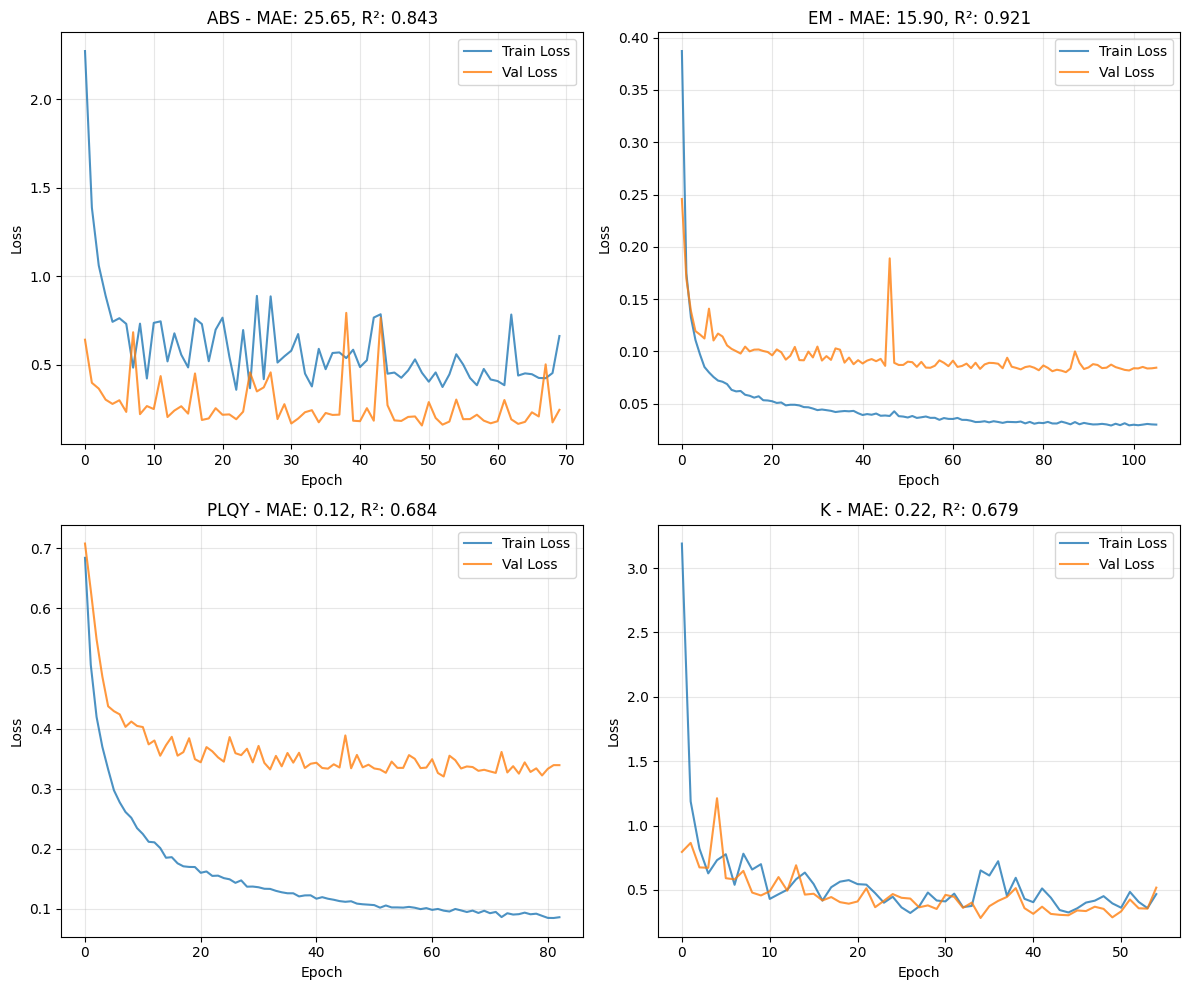

📊 Plot saved to: /content/drive/MyDrive/fluor_models/training_history.png


In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, r in enumerate(results):
    if idx >= 4:
        break
    ax = axes[idx]
    ax.plot(r['history']['train_loss'], label='Train Loss', alpha=0.8)
    ax.plot(r['history']['val_loss'], label='Val Loss', alpha=0.8)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f"{r['target'].upper()} - MAE: {r['mae']:.2f}, R²: {r['r2']:.3f}")
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(len(results), 4):
    axes[idx].axis('off')

plt.tight_layout()

# Save to Google Drive
plot_path = os.path.join(DRIVE_OUTPUT, 'training_history.png')
plt.savefig(plot_path, dpi=150)
plt.show()
print(f"📊 Plot saved to: {plot_path}")

## 11. Make Predictions

Use the trained models to predict properties for a new molecule.

In [27]:
# ============================================================================
# Prediction Input
# ============================================================================

molecule = "C2=C1C7=C(C(=[N+]1[B-]([N]3C2=C5C(=C3C4=CC=CC=C4)C=CC=C5)(F)F)C6=CC=CC=C6)C=CC=C7"
solvent = "CC1=CC=CC=C1"

print(f"🧪 Molecule: {molecule}")
print(f"🧫 Solvent:  {solvent}")

🧪 Molecule: C2=C1C7=C(C(=[N+]1[B-]([N]3C2=C5C(=C3C4=CC=CC=C4)C=CC=C5)(F)F)C6=CC=CC=C6)C=CC=C7
🧫 Solvent:  CC1=CC=CC=C1


In [30]:
# ============================================================================
# Run Prediction
# ============================================================================
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors

def predict_properties(molecule_smiles, solvent_smiles, model_dir='./models', 
                       checkpoint_dir='/content/drive/MyDrive/fluor_checkpoints', device='cuda'):
    """Predict all properties for a single molecule with proper inverse scaling."""
    
    # Generate molecular graph
    graph = smiles_to_graph(molecule_smiles)
    if graph is None:
        raise ValueError(f"Could not parse molecule SMILES: {molecule_smiles}")
    
    # Generate Morgan fingerprints (1024-bit, radius 2) - matches training data
    mol = Chem.MolFromSmiles(molecule_smiles)
    sol = Chem.MolFromSmiles(solvent_smiles)
    if mol is None or sol is None:
        raise ValueError("Invalid SMILES")
    
    mol_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
    sol_fp = AllChem.GetMorganFingerprintAsBitVect(sol, radius=2, nBits=1024)
    
    mol_fp_arr = np.array(mol_fp, dtype=np.float32)
    sol_fp_arr = np.array(sol_fp, dtype=np.float32)
    
    # Compute molecular descriptors
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)
    
    # Count double bonds (including aromatic)
    double_bonds = sum(1 for bond in mol.GetBonds() 
                       if bond.GetBondType() == Chem.BondType.DOUBLE or bond.GetIsAromatic())
    ring_count = mol.GetRingInfo().NumRings()
    
    # Placeholder values for other descriptors (tag, solvent_num, unimol_plus)
    numeric_feats = np.array([mw, logp, tpsa, 0, double_bonds, ring_count, 0, 0], dtype=np.float32)
    
    # Scaffold flags (136 zeros as placeholder - full implementation would match substructures)
    scaffold_flags = np.zeros(136, dtype=np.float32)
    
    predictions = {}
    
    for target in ['abs', 'em', 'plqy', 'k']:
        model_path = os.path.join(model_dir, f'Model_{target}.pth')
        if not os.path.exists(model_path):
            print(f"   ⚠️ Model not found: {model_path}")
            continue
        
        # Load scaler parameters from checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{target}.pth')
        scaler_mean = None
        scaler_scale = None
        
        if os.path.exists(checkpoint_path):
            ckpt = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
            scaler_mean = ckpt.get('scaler_mean', [0])[0]
            scaler_scale = ckpt.get('scaler_scale', [1])[0]
        else:
            print(f"   ⚠️ Checkpoint not found for {target}, using raw predictions")
        
        config = MODEL_CONFIGS[target]
        
        # Get feature dimensions from a sample graph
        n_feats = graph.ndata['hv'].shape[1]
        e_feats = graph.edata['he'].shape[1]
        
        # Build fingerprint tensor based on model type
        if config['model_type'] == 'attention_cnn':
            # abs/em models: [solvent_fp, mol_fp, numeric, scaffold]
            fp = np.concatenate([sol_fp_arr, mol_fp_arr, numeric_feats, scaffold_flags])
            solvent_dim = len(sol_fp_arr)
            smiles_extra_dim = len(fp) - solvent_dim
            
            model = GraphFingerprintsModelAttentionCNN(
                node_feat_size=n_feats,
                edge_feat_size=e_feats,
                solvent_dim=solvent_dim,
                smiles_extra_dim=smiles_extra_dim,
                graph_feat_size=GRAPH_FEAT_SIZE,
                num_layers=config['num_layers'],
                num_timesteps=config['num_timesteps'],
                n_tasks=1,
                dropout=config['dropout']
            )
        else:
            # plqy/k models: [solvent_fp, mol_fp, numeric, scaffold]
            fp = np.concatenate([sol_fp_arr, mol_fp_arr, numeric_feats, scaffold_flags])
            
            model = GraphFingerprintsModelSimpleFC(
                node_feat_size=n_feats,
                edge_feat_size=e_feats,
                fp_size=len(fp),
                graph_feat_size=GRAPH_FEAT_SIZE,
                num_layers=config['num_layers'],
                num_timesteps=config['num_timesteps'],
                n_tasks=1,
                dropout=config['dropout']
            )
        
        # Load weights
        model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
        model = model.to(device)
        model.eval()
        
        # Prepare inputs
        graph_batch = dgl.batch([graph]).to(device)
        node_feats = graph_batch.ndata['hv']
        edge_feats = graph_batch.edata['he']
        fp_tensor = torch.tensor(fp, dtype=torch.float32).unsqueeze(0).to(device)
        
        # Predict
        with torch.no_grad():
            pred = model(graph_batch, node_feats, edge_feats, fp_tensor)
            pred_scaled = pred.item()
        
        # Inverse transform: original = scaled * scale + mean
        if scaler_mean is not None and scaler_scale is not None:
            pred_value = pred_scaled * scaler_scale + scaler_mean
        else:
            pred_value = pred_scaled
        
        predictions[target] = pred_value
    
    return predictions

# Run prediction
print("\n🔮 Running predictions...")
preds = predict_properties(molecule, solvent, model_dir=OUTPUT_DIR, 
                           checkpoint_dir=CHECKPOINT_DIR, device=device)

print("\n" + "="*50)
print("📊 PREDICTION RESULTS")
print("="*50)
print(f"   Absorption (abs):    {preds.get('abs', 'N/A'):.1f} nm")
print(f"   Emission (em):       {preds.get('em', 'N/A'):.1f} nm")
print(f"   Quantum Yield (plqy): {preds.get('plqy', 'N/A'):.3f}")
print(f"   Log ε (k):           {preds.get('k', 'N/A'):.2f}")
print("="*50)


🔮 Running predictions...

📊 PREDICTION RESULTS
   Absorption (abs):    10.0 nm
   Emission (em):       57.6 nm
   Quantum Yield (plqy): 3.775
   Log ε (k):           -4.20


In [ ]:
# ============================================================================
# Compare Old (Pretrained) vs New (Just Trained) Models
# ============================================================================

OLD_MODEL_DIR = './fluor_tools/Fluor-RLAT'  # Original pretrained models from repo
NEW_MODEL_DIR = './models'  # Newly trained models

print("🔬 Comparing pretrained vs newly trained models\n")
print(f"Molecule: {molecule}")
print(f"Solvent:  {solvent}\n")

# Check which models exist
old_models_exist = all(os.path.exists(os.path.join(OLD_MODEL_DIR, f'Model_{t}.pth')) for t in ['abs', 'em', 'plqy', 'k'])
new_models_exist = all(os.path.exists(os.path.join(NEW_MODEL_DIR, f'Model_{t}.pth')) for t in ['abs', 'em', 'plqy', 'k'])

print(f"Old models found: {'✅' if old_models_exist else '❌'} ({OLD_MODEL_DIR})")
print(f"New models found: {'✅' if new_models_exist else '❌'} ({NEW_MODEL_DIR})")

if old_models_exist and new_models_exist:
    print("\n🔮 Running predictions with both model sets...")
    
    # Note: Old models need their own scaler params - we'll use checkpoint for new models only
    old_preds = predict_properties(molecule, solvent, model_dir=OLD_MODEL_DIR, 
                                   checkpoint_dir=CHECKPOINT_DIR, device=device)
    new_preds = predict_properties(molecule, solvent, model_dir=NEW_MODEL_DIR, 
                                   checkpoint_dir=CHECKPOINT_DIR, device=device)
    
    print("\n" + "="*70)
    print("📊 MODEL COMPARISON")
    print("="*70)
    print(f"{'Property':<25} {'Old Model':<20} {'New Model':<20} {'Diff':<10}")
    print("-"*70)
    
    for prop, unit, fmt in [('abs', 'nm', '.1f'), ('em', 'nm', '.1f'), ('plqy', '', '.3f'), ('k', '', '.2f')]:
        old_val = old_preds.get(prop, float('nan'))
        new_val = new_preds.get(prop, float('nan'))
        diff = new_val - old_val
        
        old_str = f"{old_val:{fmt}} {unit}".strip()
        new_str = f"{new_val:{fmt}} {unit}".strip()
        diff_str = f"{diff:+{fmt}}"
        
        prop_name = {'abs': 'Absorption', 'em': 'Emission', 'plqy': 'Quantum Yield', 'k': 'Log ε'}[prop]
        print(f"{prop_name:<25} {old_str:<20} {new_str:<20} {diff_str:<10}")
    
    print("="*70)
else:
    if not old_models_exist:
        print(f"\n⚠️ Old models not found in {OLD_MODEL_DIR}")
    if not new_models_exist:
        print(f"\n⚠️ New models not found in {NEW_MODEL_DIR}")